In [ ]:
# install necessary libraries
#!pip install torch torchvision torchaudio
#!pip install transformers datasets
#!pip install timm
#!pip install matplotlib pillow tqdm
#!pip install accelerate
#!pip install pytorch-lightning

In [7]:
# import necessary libraries
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, AutoModelForCausalLM, ViTModel
from datasets import load_dataset, concatenate_datasets
# from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# load dataset
#dataset = load_dataset("jxie/flickr8k")
dataset = load_dataset("jxie/flickr8k")

# combine train and validation for extra training
#flickr_data = dataset['train']
flickr_train = dataset["train"]
flickr_val   = dataset["validation"]
flickr_data = concatenate_datasets([flickr_train, flickr_val])

print(f"Columns: {flickr_data.column_names}")
print(f"Number of examples: {len(flickr_data)}")

Columns: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4']
Number of examples: 7000


In [3]:
# image transformations
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3,[0.5]*3)
])

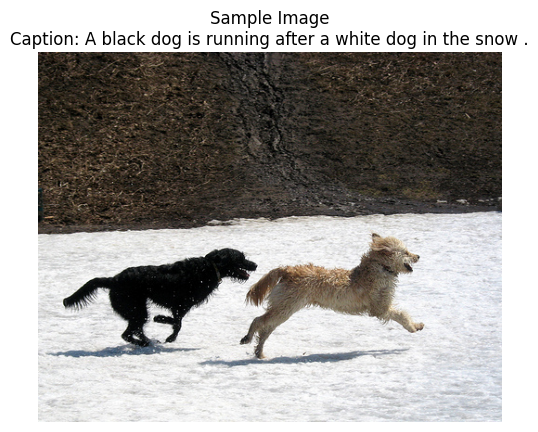

In [4]:
# test image
sample_img = flickr_data[0]['image']
plt.imshow(sample_img)
plt.title(f"Sample Image\nCaption: {flickr_data[0]['caption_0']}")
plt.axis('off')
plt.show()


In [5]:
# make dataset class
class Flickr8kDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=30, transform=None):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        if self.transform:
            image = self.transform(image)
        caption = self.dataset[idx]['caption_0']
        tokenized = self.tokenizer(
            caption,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = tokenized.input_ids.squeeze(0)
        attention_mask = tokenized.attention_mask.squeeze(0)
        return image, input_ids, attention_mask

In [ ]:
# load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token

# add special <img> token
if '<img>' not in tokenizer.get_vocab():
    tokenizer.add_special_tokens({'additional_special_tokens':['<img>']})
img_token_id = tokenizer.convert_tokens_to_ids('<img>')

# load DistilGPT2 via AutoModelForCausalLM
gpt2 = AutoModelForCausalLM.from_pretrained("distilgpt2")
gpt2.resize_token_embeddings(len(tokenizer))
gpt2.eval()

c:\Users\Thomas\Desktop\CompVis\Final\glip-env\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\Thomas\Desktop\CompVis\Final\glip-env\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

In [9]:
# make q-former, use len of 16
vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
vit.eval()

class QFormer(nn.Module):
    def __init__(self, image_emb_dim, prompt_len=16, hidden_dim=768):
        super().__init__()
        self.query_tokens = nn.Parameter(torch.randn(prompt_len, image_emb_dim))
        self.cross_attn = nn.MultiheadAttention(embed_dim=image_emb_dim, num_heads=8)
        self.mlp = nn.Linear(image_emb_dim, hidden_dim)
        
    def forward(self, image_embeds):
        batch_size = image_embeds.size(0)
        query = self.query_tokens.unsqueeze(1).repeat(1,batch_size,1)
        attn_out,_ = self.cross_attn(query, image_embeds.transpose(0,1), image_embeds.transpose(0,1))
        prompt = self.mlp(attn_out).transpose(0,1)
        return prompt

q_former = QFormer(image_emb_dim=vit.config.hidden_size, prompt_len=16, hidden_dim=gpt2.config.n_embd)

c:\Users\Thomas\Desktop\CompVis\Final\glip-env\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
# load data and set up the device
train_dataset = Flickr8kDataset(flickr_data, tokenizer, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit.to(device)
gpt2.to(device)
q_former.to(device)

QFormer(
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (mlp): Linear(in_features=768, out_features=768, bias=True)
)

In [ ]:
import os

# save locations
checkpoint_dir = "checkpoints"
samples_dir = "epoch_samples"

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(samples_dir, exist_ok=True)

In [ ]:
# function to save sample captions from epochs
def save_epoch_samples(dataset, generate_fn, epoch, file_path):
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(f"===== Samples for Epoch {epoch} =====\n\n")

        # select first 10 dataset indices
        indices = list(range(10))

        for idx in indices:
            item = dataset[idx]
            img = item['image'].convert("RGB")
            # gt_caption = item['caption']
            gt_caption = item.get("caption_0", "N/A")
            gen_caption = generate_fn(img)

            f.write("GT caption: " + gt_caption + "\n")
            f.write("Generated caption: " + gen_caption + "\n")
            f.write("\n---------------------------------------\n\n")

    print(f"Saved sample captions → {file_path}")

In [11]:
# function to generate caption
def generate_caption(pil_image, vit, q_former, gpt2, tokenizer, device, max_length=30):
    vit.eval()
    q_former.eval()
    gpt2.eval()
    
    image = transform(pil_image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_embeds = vit(image).last_hidden_state
        prompts = q_former(image_embeds)
        input_ids = torch.tensor([[tokenizer.bos_token_id]], device=device)
        img_token_emb = gpt2.transformer.wte(torch.tensor([[img_token_id]], device=device))
        generated = []

        for _ in range(max_length):
            gpt2_inputs = gpt2.transformer.wte(input_ids)
            gpt2_inputs = torch.cat([img_token_emb, prompts, gpt2_inputs], dim=1)
            
            outputs = gpt2(inputs_embeds=gpt2_inputs)
            logits = outputs.logits[0, -1, :]
            
            filtered_logits = torch.nn.functional.softmax(logits, dim=-1)
            next_token = torch.multinomial(filtered_logits, num_samples=1)
            
            if next_token.item() == tokenizer.eos_token_id:
                break
            generated.append(next_token.item())
            input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)
        
        caption = tokenizer.decode(generated, skip_special_tokens=True)
        return caption

In [ ]:
# prepare GPT-2 for fine-tuning
N_LAST_LAYERS = 4  # fine-tune last 4 layers
NUM_EPOCH = 10

# Freeze all GPT-2 parameters
for param in gpt2.transformer.parameters():
    param.requires_grad = False

# Unfreeze last N layers, token embedding, and LM head
for block in gpt2.transformer.h[-N_LAST_LAYERS:]:
    for param in block.parameters():
        param.requires_grad = True
for param in gpt2.transformer.wte.parameters():
    param.requires_grad = True
for param in gpt2.lm_head.parameters():
    param.requires_grad = True

# optimizer for trainable params
trainable_params = filter(lambda p: p.requires_grad, gpt2.parameters())
optimizer = torch.optim.AdamW(list(trainable_params) + list(q_former.parameters()), lr=5e-5)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

In [ ]:
# training
for epoch in range(NUM_EPOCH):
    q_former.train()
    gpt2.train()
    total_loss = 0
    for images, input_ids, attention_mask in tqdm(train_loader):
        images, input_ids = images.to(device), input_ids.to(device)

        with torch.no_grad():
            image_embeds = vit(images).last_hidden_state
        
        prompts = q_former(image_embeds)
        
        img_token_emb = gpt2.transformer.wte(torch.tensor([img_token_id]*images.size(0), device=device).unsqueeze(1))
        gpt2_inputs = gpt2.transformer.wte(input_ids)
        gpt2_inputs = torch.cat([img_token_emb, prompts, gpt2_inputs], dim=1)
        
        outputs = gpt2(inputs_embeds=gpt2_inputs)
        logits = outputs.logits
        
        prompt_len = 1 + prompts.size(1)
        loss = criterion(logits[:, prompt_len:-1,:].reshape(-1, logits.size(-1)), input_ids[:,1:].reshape(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch} Loss: {avg_loss:.4f}")

    # save final epoch (could do more but I don't have space on device to save each model)
    if (epoch == NUM_EPOCH - 1):
        save_path = os.path.join(checkpoint_dir, "model.pt")
        torch.save({
            "epoch": epoch,
            "q_former": q_former.state_dict(),
            "gpt2": gpt2.state_dict(),
            "optimizer": optimizer.state_dict(),
            "loss": avg_loss
        }, save_path)
        print(f"Saved checkpoint → {save_path}")

    # save sample captions for this epoch
    sample_file = os.path.join(samples_dir, f"epoch_{epoch}_samples.txt")
    with open(sample_file, "w", encoding="utf-8") as f:
        f.write(f"===== Samples for Epoch {epoch} =====\n\n")

        indices = list(range(10))

        for idx in indices:
            img = flickr_data[idx]['image']
            gt_caption = flickr_data[idx]['caption_0']
            gen_caption = generate_caption(img, vit, q_former, gpt2, tokenizer, device)

            f.write("GT caption: " + gt_caption + "\n")
            f.write("Generated caption: " + gen_caption + "\n")
            f.write("\n---------------------------------------\n\n")

    print(f"Saved sample captions → {sample_file}")


100%|██████████| 1750/1750 [1:10:55<00:00,  2.43s/it]


Epoch 0 Loss: 3.3689
Saved sample captions → epoch_samples\epoch_0_samples.txt


100%|██████████| 1750/1750 [1:13:27<00:00,  2.52s/it]


Epoch 1 Loss: 2.7075
Saved sample captions → epoch_samples\epoch_1_samples.txt


100%|██████████| 1750/1750 [1:11:33<00:00,  2.45s/it]


Epoch 2 Loss: 2.4382
Saved sample captions → epoch_samples\epoch_2_samples.txt


100%|██████████| 1750/1750 [1:12:15<00:00,  2.48s/it]


Epoch 3 Loss: 2.2131
Saved sample captions → epoch_samples\epoch_3_samples.txt


100%|██████████| 1750/1750 [1:15:00<00:00,  2.57s/it]


Epoch 4 Loss: 1.9948
Saved sample captions → epoch_samples\epoch_4_samples.txt


100%|██████████| 1750/1750 [1:11:45<00:00,  2.46s/it]


Epoch 5 Loss: 1.7784
Saved sample captions → epoch_samples\epoch_5_samples.txt


100%|██████████| 1750/1750 [1:10:32<00:00,  2.42s/it]


Epoch 6 Loss: 1.5754
Saved sample captions → epoch_samples\epoch_6_samples.txt


100%|██████████| 1750/1750 [1:10:41<00:00,  2.42s/it]


Epoch 7 Loss: 1.3732
Saved sample captions → epoch_samples\epoch_7_samples.txt


100%|██████████| 1750/1750 [1:19:02<00:00,  2.71s/it]


Epoch 8 Loss: 1.1837
Saved sample captions → epoch_samples\epoch_8_samples.txt


100%|██████████| 1750/1750 [1:19:00<00:00,  2.71s/it]


Epoch 9 Loss: 1.0062
Saved checkpoint → checkpoints\model.pt
Saved sample captions → epoch_samples\epoch_9_samples.txt


GT caption: The dogs are in the snow in front of a fence .
Generated caption:  on a snowy day. 3 St Bernard has a colourful brown dog beside him in the snow. 3 people in the brown coat stand. 3 dogs


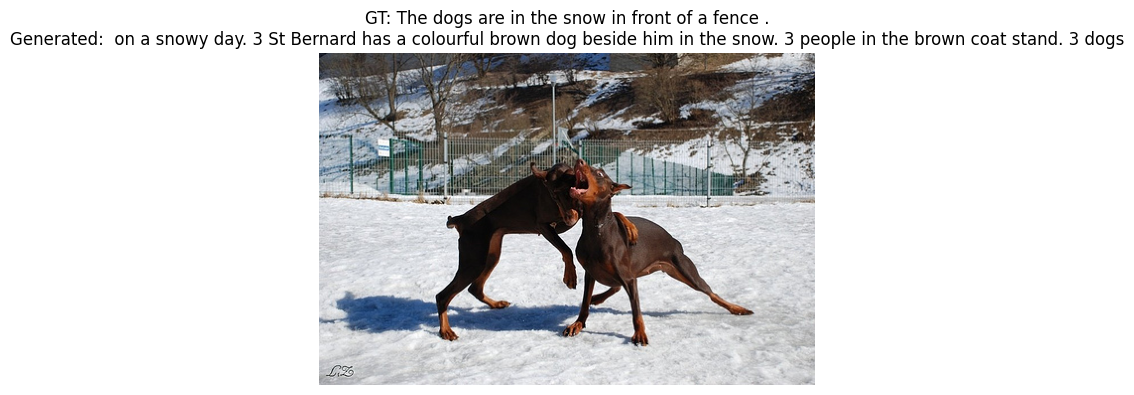

GT caption: a brown and white dog swimming towards some in the pool
Generated caption:  old woman and a toddler are in an agility pool. Rollerblading across a sandy beach. Rescue is under way. Rescue begins. Rescue ends


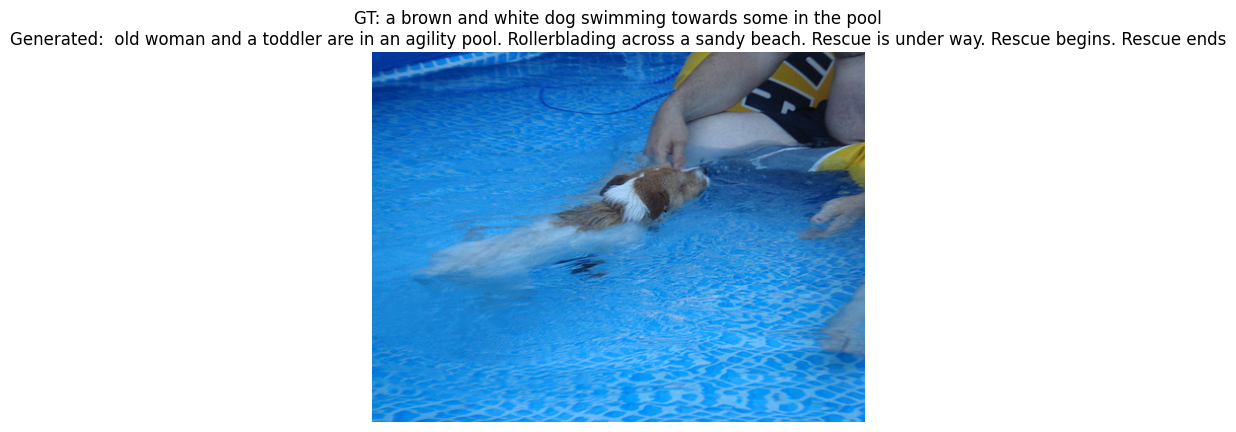

GT caption: A man and a woman in festive costumes dancing .
Generated caption:  men in swimwear and leather vests are being perforced into large stride whilst wearing minimal amounts of fabric... Another person is covering their


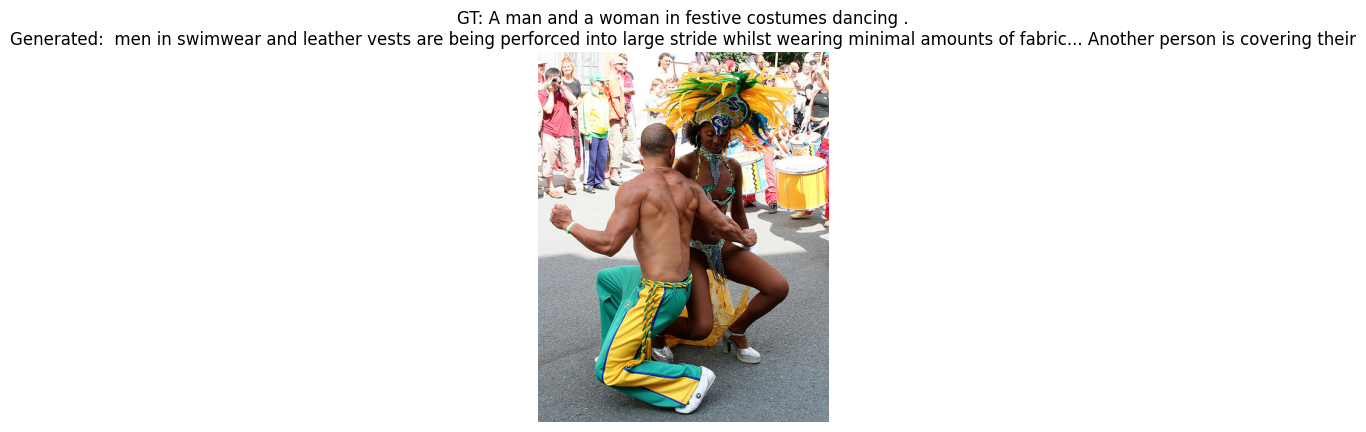

GT caption: A couple of people sit outdoors at a table with an umbrella and talk .
Generated caption:  up on a stone wall with a view in the background. a man and a woman leaning on something with their backs to the camera. a woman


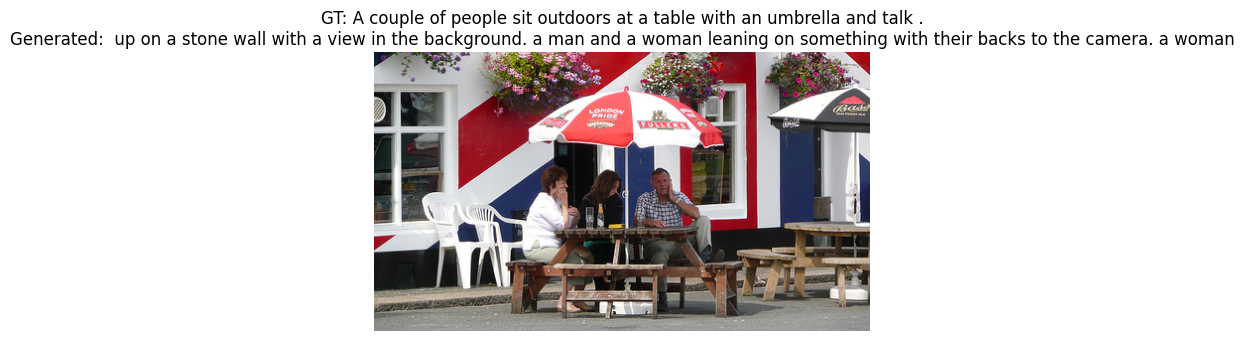

GT caption: A man is wearing a Sooners red football shirt and helmet .
Generated caption:  football players are playing football. Quarterback in black and white. Quarterback in red and white. Quarterback in blue and white. Quarterback


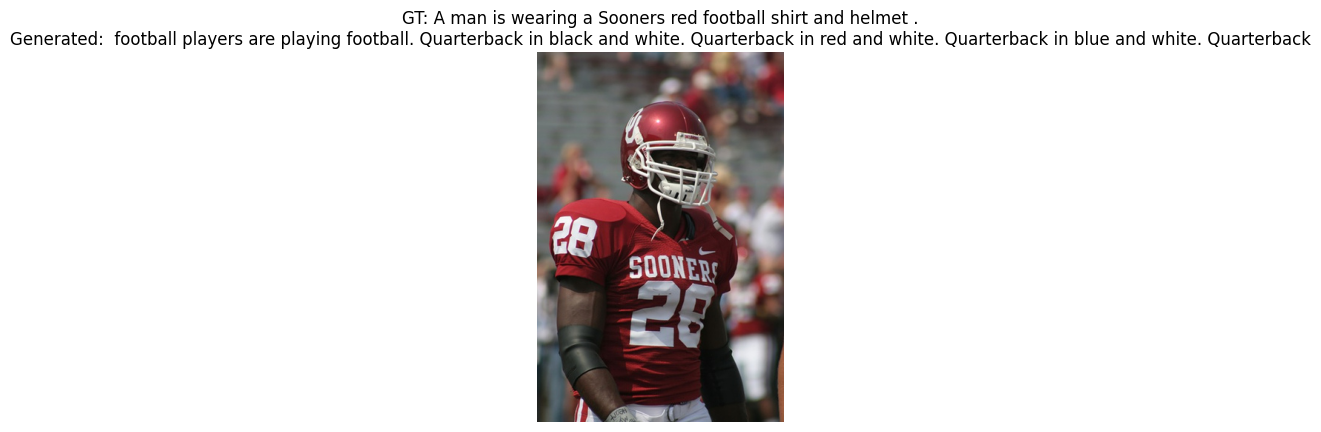

GT caption: A brown dog running
Generated caption:  of cartwheels are bending over backwards.. a lighter colored dog runs away. an older dog. an older dog runs with a huge tire


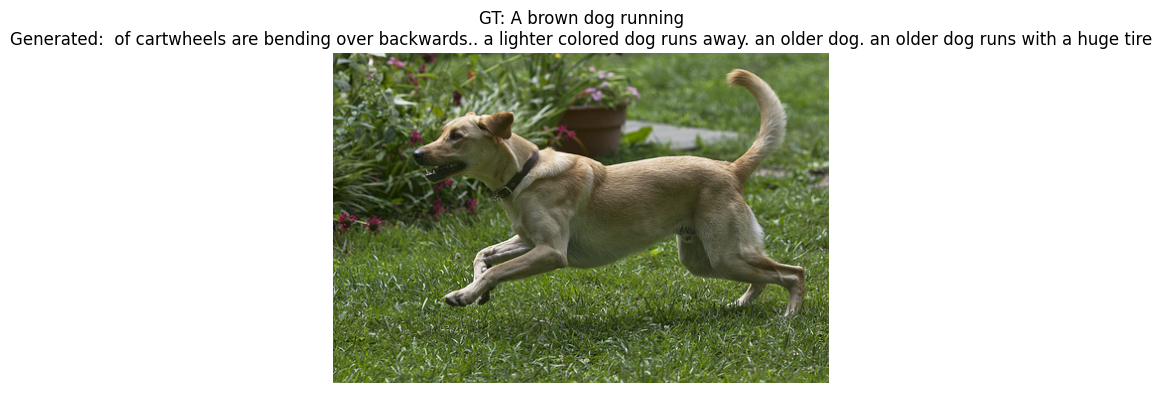

GT caption: A girl with dark brown hair and eyes in a blue scarf is standing next to a girl in a fur edged coat .
Generated caption:  in the dark night.com circus surrounded by adults.com, takes place at dusk.com.com. Candidates are being called to a


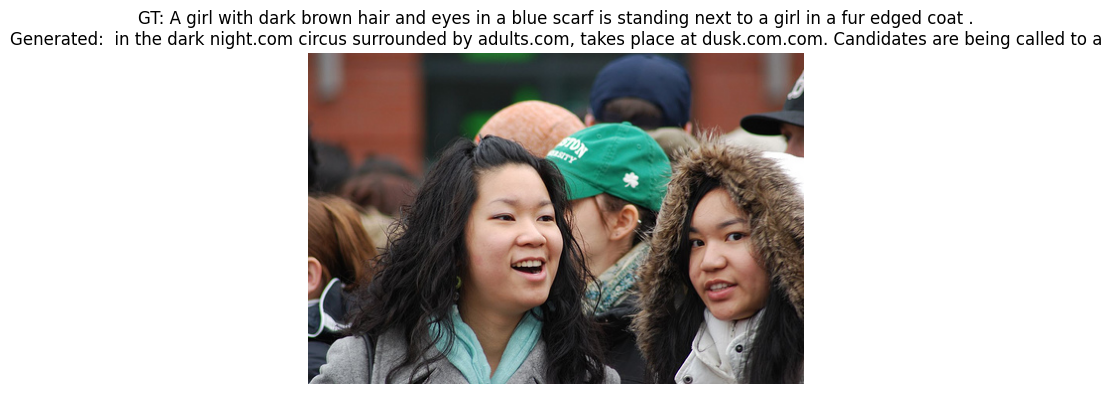

GT caption: A dog with its mouth opened .
Generated caption:  of a brown and white dog by a tree. white and a black dog are jumping. orange colored. each with a red toy in its mouth


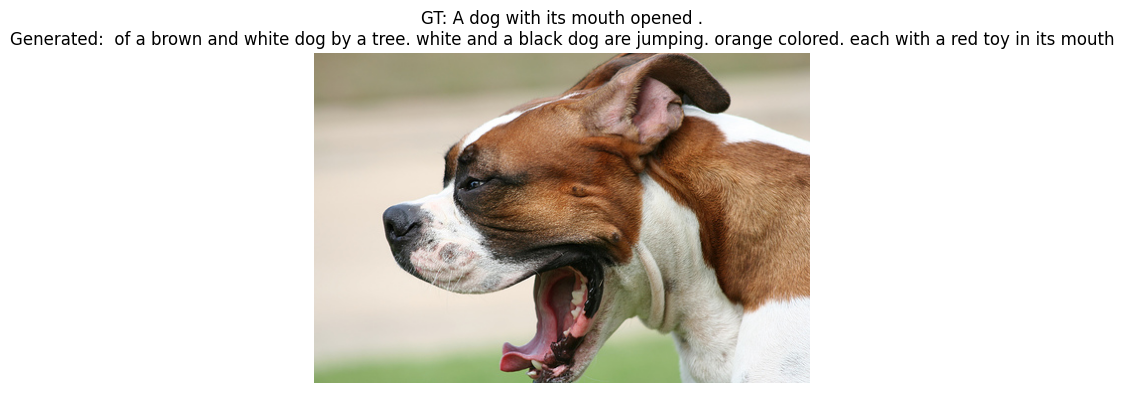

GT caption: A black dog emerges from the water onto the sand , holding a white object in its mouth .
Generated caption:  asian dogs jumping over a large rock. big red object in the snow. blue object reflects. blue light blue. with a reddish colored


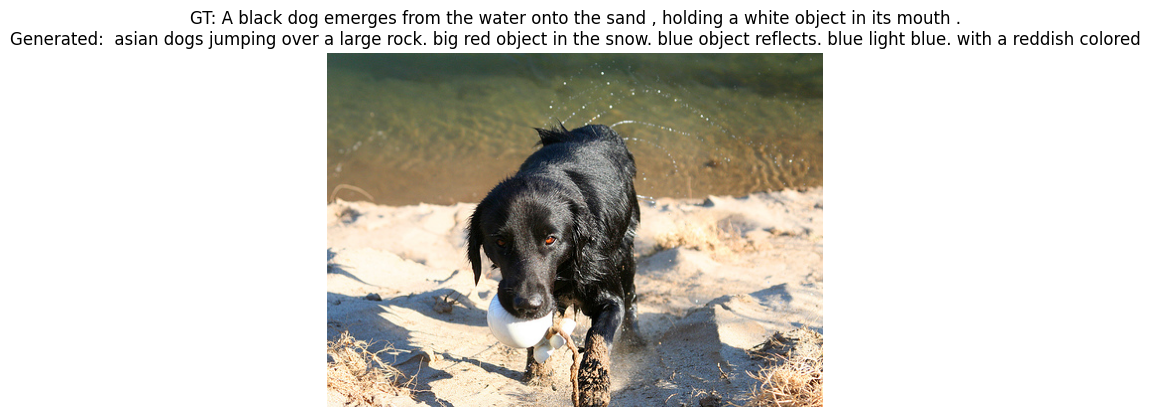

GT caption: A player from the white and green highschool team dribbles down court defended by a player from the other team .
Generated caption:  top basketball players on the court are making a jump in their attempts to block a shot from outside. basketball player on the other hand is trying to


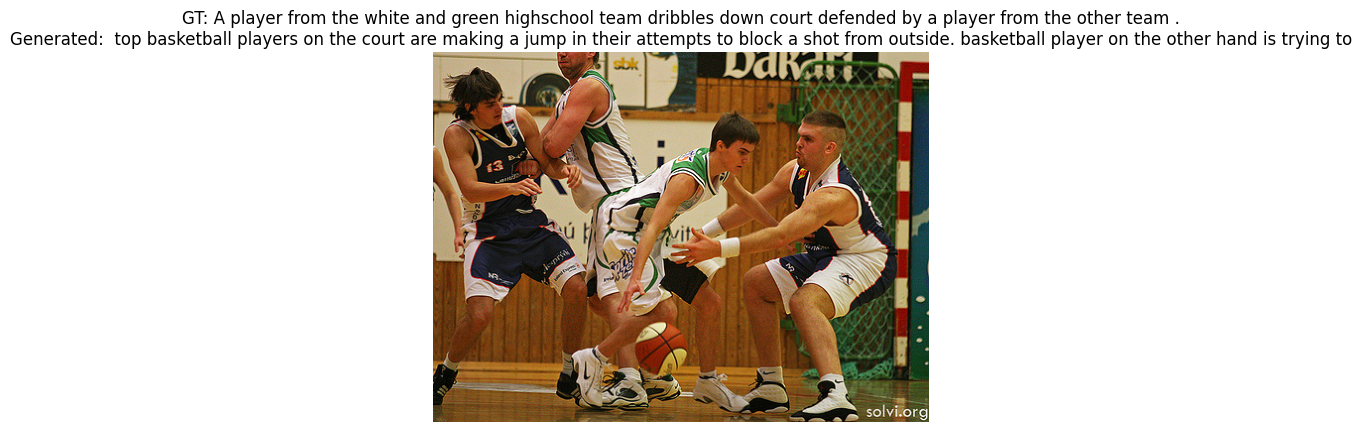

In [ ]:
# test on images from test set
flickr_test = dataset["test"]
for i in range(10):
    img = flickr_test[i]['image']
    gt_caption = flickr_test[i]['caption_0']
    gen_caption = generate_caption(img, vit, q_former, gpt2, tokenizer, device)

    print("GT caption: " + gt_caption)
    print("Generated caption: " + gen_caption)
    
    plt.imshow(img)
    plt.title(f"GT: {gt_caption}\nGenerated: {gen_caption}")
    plt.axis('off')
    plt.show()